In [1]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cols  = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration', 'num_doors', 'body_style',
         'drive_wheels', 'engine_location', 'wheel_base', 'length', 'width', 'height', 'curb_weight',
         'engine_type', 'num_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_ratio',
         'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price'] 

pd.set_option('display.max_columns', len(cols))

In [3]:
cars = pd.read_csv('imports-85.data', names=cols)

In [4]:
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [5]:
cars.describe()

,symboling,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,city_mpg,highway_mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


In [6]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized_losses    205 non-null object
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num_doors            205 non-null object
body_style           205 non-null object
drive_wheels         205 non-null object
engine_location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_cylinders        205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression_ratio    205 non-null float64
horsepower           205 non-nul

#### Potentially numeric columns

In [7]:
numeric = cars.select_dtypes(object).iloc[:, -5:].columns.tolist()

In [8]:
numeric.append('normalized_losses')

In [9]:
for col in numeric:
    col_name = '{}_str'.format(col)
    cars[col_name] = cars[col].apply(lambda val: re.match('[^0-9.]', val))
    print(cars[~cars[col_name].isna()].iloc[:, -5:])
    cars.drop('{}_str'.format(col), axis=1, inplace=True)

   peak_rpm  city_mpg  highway_mpg  price  \
55     6000        17           23  10945   
56     6000        17           23  11845   
57     6000        17           23  13645   
58     6000        16           23  15645   

                                           bore_str  
55  <_sre.SRE_Match object; span=(0, 1), match='?'>  
56  <_sre.SRE_Match object; span=(0, 1), match='?'>  
57  <_sre.SRE_Match object; span=(0, 1), match='?'>  
58  <_sre.SRE_Match object; span=(0, 1), match='?'>  
   peak_rpm  city_mpg  highway_mpg  price  \
55     6000        17           23  10945   
56     6000        17           23  11845   
57     6000        17           23  13645   
58     6000        16           23  15645   

                                         stroke_str  
55  <_sre.SRE_Match object; span=(0, 1), match='?'>  
56  <_sre.SRE_Match object; span=(0, 1), match='?'>  
57  <_sre.SRE_Match object; span=(0, 1), match='?'>  
58  <_sre.SRE_Match object; span=(0, 1), match='?'>  
    peak

In [10]:
for col in numeric:
    cars[col] = cars[col].replace('?', np.nan)

In [11]:
cars[numeric] = cars[numeric].astype('float')

In [12]:
cars.isna().sum()

symboling             0
normalized_losses    41
make                  0
fuel_type             0
aspiration            0
num_doors             0
body_style            0
drive_wheels          0
engine_location       0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
num_cylinders         0
engine_size           0
fuel_system           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

In [13]:
cars.dropna(axis=0, subset=['bore', 'stroke', 'horsepower', 'peak_rpm', 'price'], inplace=True)
cars.drop(['normalized_losses'], axis=1, inplace=True)

### Normalizing values

In [15]:
numeric_sub = cars.select_dtypes([float, int]).drop(['price'], axis=1)
numeric_sub = (numeric_sub - numeric_sub.min())/(numeric_sub.max() - numeric_sub.min())
numeric_sub

,symboling,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,1.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.12500,0.294393,0.346939,0.222222,0.289474
1,1.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.12500,0.294393,0.346939,0.222222,0.289474
2,0.6,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.12500,0.495327,0.346939,0.166667,0.263158
3,0.8,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.18750,0.252336,0.551020,0.305556,0.368421
4,0.8,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.06250,0.313084,0.551020,0.138889,0.157895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.2,0.655977,0.711940,0.735043,0.641667,0.567882,0.301887,0.885714,0.514286,0.15625,0.308411,0.510204,0.277778,0.315789
201,0.2,0.655977,0.711940,0.726496,0.641667,0.605508,0.301887,0.885714,0.514286,0.10625,0.523364,0.469388,0.166667,0.236842
202,0.2,0.655977,0.711940,0.735043,0.641667,0.591156,0.422642,0.742857,0.380952,0.11250,0.401869,0.551020,0.138889,0.184211
203,0.2,0.655977,0.711940,0.735043,0.641667,0.670675,0.316981,0.335714,0.633333,1.00000,0.271028,0.265306,0.361111,0.289474


In [16]:
cars.isna().sum()

symboling            0
make                 0
fuel_type            0
aspiration           0
num_doors            0
body_style           0
drive_wheels         0
engine_location      0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_type          0
num_cylinders        0
engine_size          0
fuel_system          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
price                0
dtype: int64

In [17]:
data = pd.concat([numeric_sub, cars[['price']]], axis=1)

### K-neighbors model

In [18]:
def knn_train_test(ftr_cols, target_col, data, **kwargs):
    # split data to train and test datasets
    shp = data.shape[0]
    train_shp = 3*shp//4
    train = data.iloc[:train_shp]
    test = data.iloc[train_shp:]
    x_train, y_train = train[ftr_cols], train[target_col]
    x_test, y_test = test[ftr_cols], test[target_col]
    # instatinate & fit KNN model
    fold = KFold(5, shuffle=True, random_state=1)
    knn = KNeighborsRegressor(**kwargs)
    mses = cross_val_score(knn, data[ftr_cols], data['price'],
                           scoring='neg_mean_squared_error', cv=fold)
    sqrt_avg_err = np.sqrt(abs(np.mean(mses)))
    return sqrt_avg_err

In [68]:
err = knn_train_test(['horsepower'], ['price'], data, n_neighbors=2)

In [69]:
err

4230.095075612125

### univariate models for various no. of neighbors

In [70]:
errors = defaultdict(dict)
for k in range(1,11,2):
    for col in data.columns[:-1]:
        err = knn_train_test([col], 'price', data, n_neighbors=k)
        errors[col][k] = err

errors = pd.DataFrame.from_dict(errors)

In [71]:
errors

,symboling,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
1,9057.271838,4660.454616,5271.773883,5447.382875,9458.243848,5857.118634,3529.441228,6776.934372,8091.456688,7333.924128,4246.236375,9523.438475,4688.905617,5503.768240
3,8977.505298,5537.598016,5046.749369,4269.443350,8145.689876,5088.010900,3182.448344,6129.007565,7243.305916,6609.266750,4263.176230,8347.978805,4140.648732,4513.496261
5,9471.813520,6016.720360,4989.034035,4700.645766,7557.173803,4585.555508,3210.731247,6895.490677,7129.364007,6548.182468,4263.156443,7820.141075,3896.072731,4190.121747
7,9481.290603,6007.109689,5316.757319,4711.725483,7546.959829,4377.807497,3458.502790,6796.793692,7256.942881,6430.671788,4362.736770,7845.848143,4133.320860,4166.091813
9,9291.871029,6072.200639,5530.379419,4602.302802,7607.202856,4233.528964,3333.125788,6880.914489,7354.055826,6584.533908,4427.335765,7622.196792,4323.084573,4204.920048


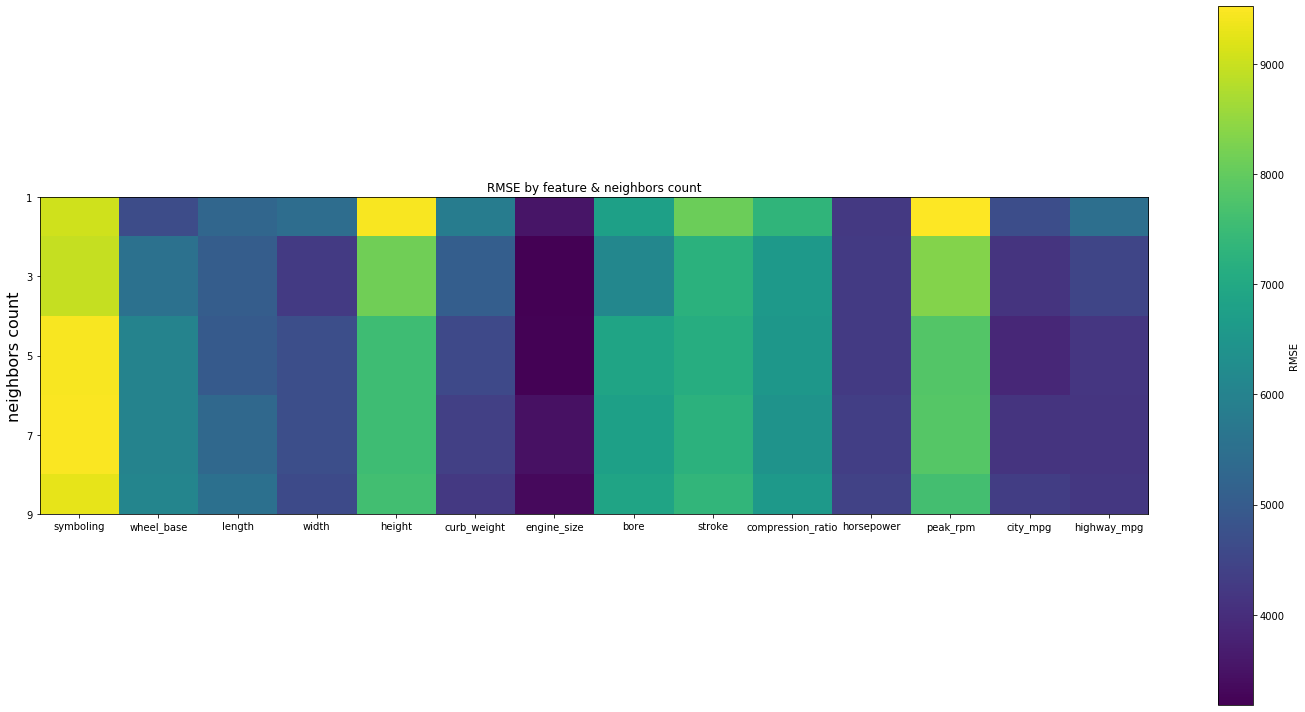

In [72]:
fig = plt.figure(figsize=(20,10))
plt.imshow(errors)
plt.figsize = (20,10)
plt.colorbar(label='RMSE')
plt.yticks(np.arange(5), errors.index.values);
plt.xticks(np.arange(len(errors.columns)), errors.columns);
plt.ylabel('neighbors count', fontdict={'size':16})
plt.tight_layout()
plt.title('RMSE by feature & neighbors count');

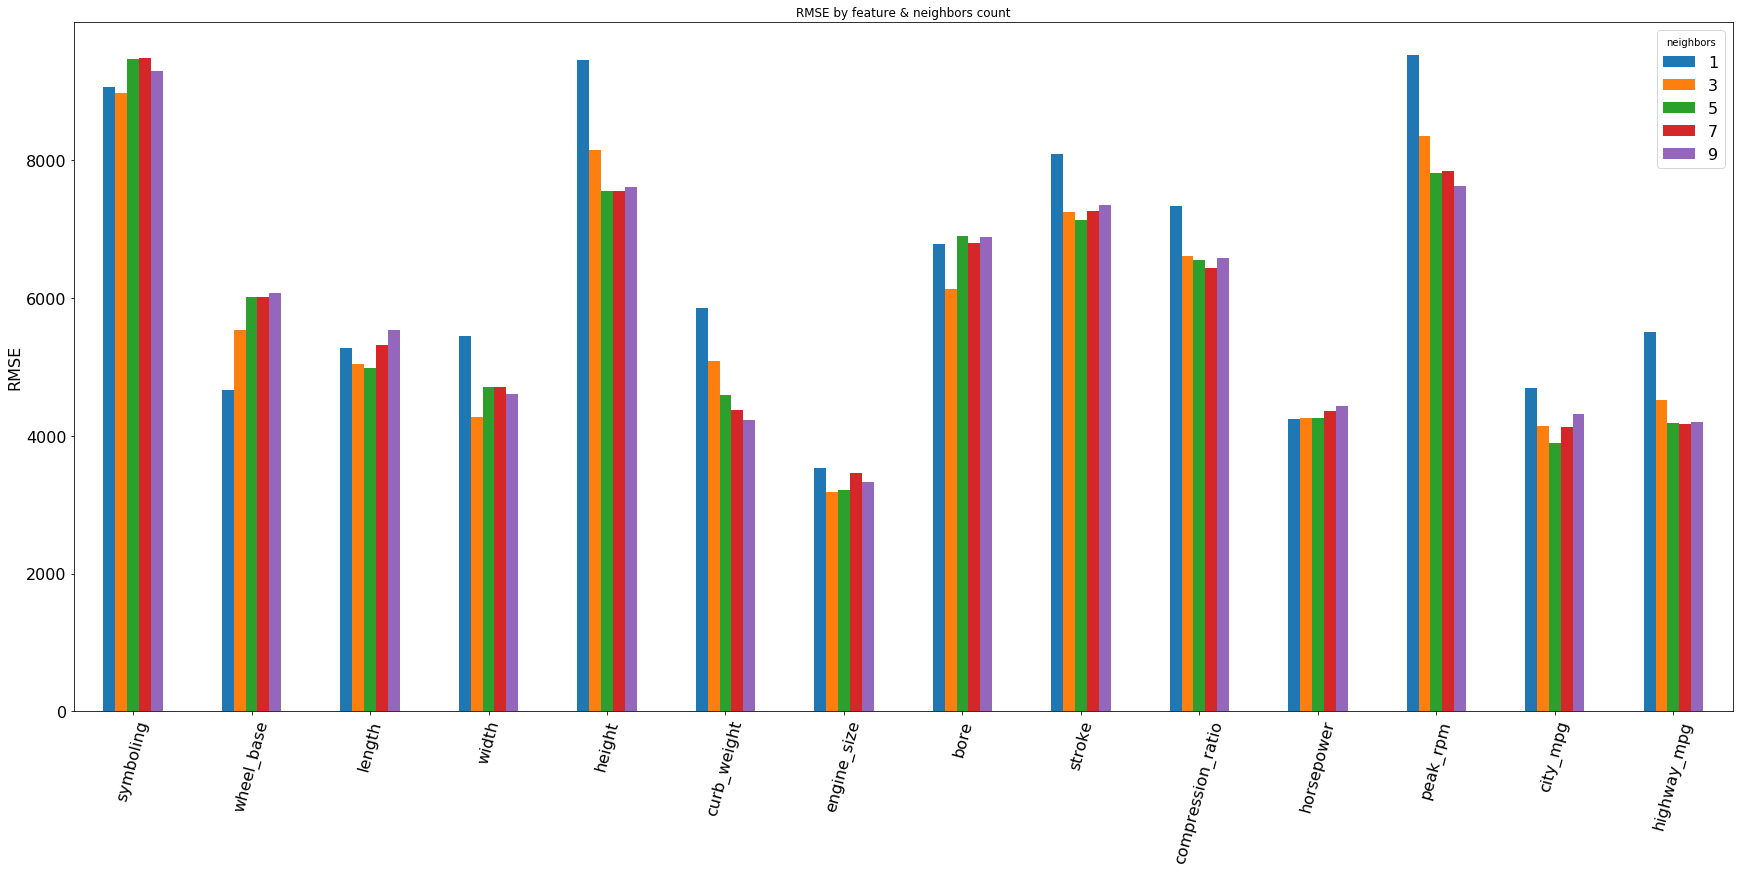

In [73]:
errors.T.plot(kind='bar', figsize=(24,12), fontsize=16, rot=75);
plt.legend(fontsize=16, title='neighbors')
plt.tight_layout()
plt.ylabel('RMSE', fontdict={'size':16})
plt.title('RMSE by feature & neighbors count');

### multivariate model for best 5 features

In [74]:
# 5 best features ordered by score
features = [
    'engine_size',
    'city_mpg',
    'curb_weight',
    'horsepower',
    'width',
]

In [75]:
# we will fit the model with 2, 3, 4 & 5 best features
errors_multivariate = {}
for ftr_no in range(2, 6):
    ftr = features[:ftr_no]
    err = knn_train_test(ftr, 'price', data)
    errors_multivariate[ftr_no] = err

In [76]:
errors_multivariate

{2: 3229.7553820843095,
 3: 3284.801215419361,
 4: 3207.423167718989,
 5: 3406.906016931657}

In [77]:
# hyperparams optimization!! 
errors_multivariate = defaultdict(dict)
for k in range(1, 26):
    for ftr_no in range(1, 6):
        ftr = features[:ftr_no]
        err = knn_train_test(ftr, 'price', data, n_neighbors=k)
        errors_multivariate[ftr_no][k] = err

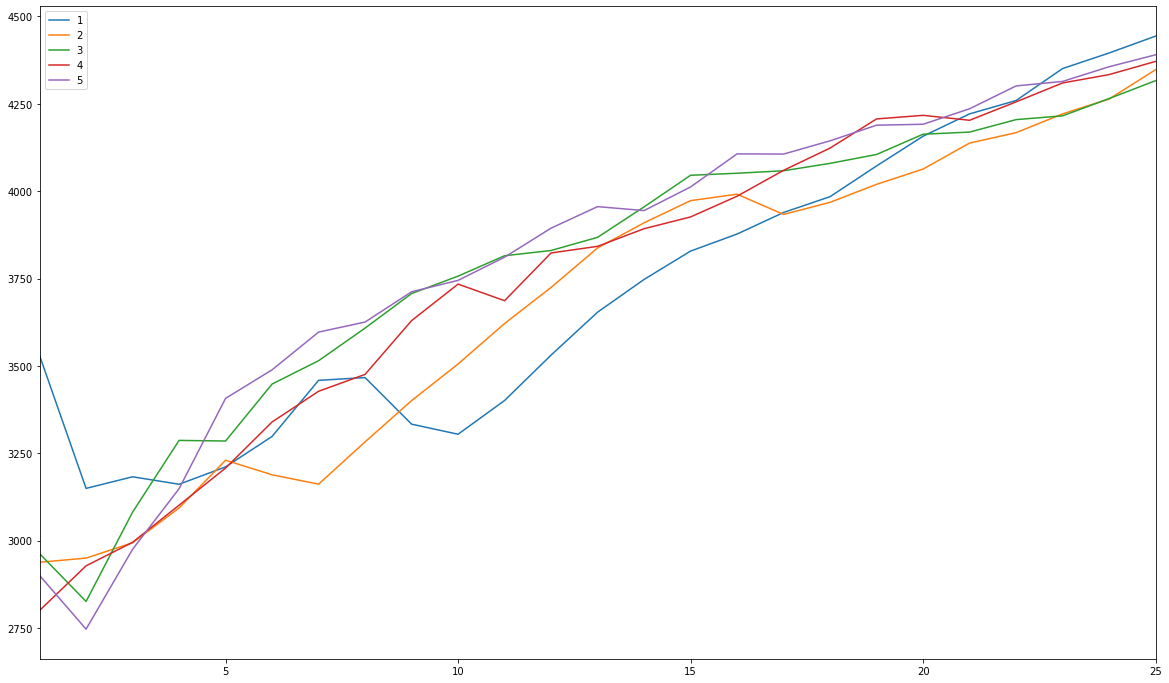

In [78]:
errs = pd.DataFrame.from_dict(errors_multivariate)
errs.plot(figsize=(20,12));